## 1. Price from the Split Pool

The function

In [1]:
def compute_k_piecewise(x, y):
    if x <= 0 or y <= 0:
        raise ValueError("Both x and y must be positive.")
    if x <= y:
        return 1 - x / (2 * y)
    else:
        return y / (2 * x)

**Mathematical Description:**

- **Case A:** If \( x \le y \):
  \[
  k = 1 - \frac{x}{2y}.
  \]
- **Case B:** If \( x > y \):
  \[
  k = \frac{y}{2x}.
  \]

**Examples:**
- If \( x = 250 \) and \( y = 500 \):
  \[
  k = 1 - \frac{250}{2\cdot500} = 1 - \frac{250}{1000} = 1 - 0.25 = 0.75.
  \]
- If \( x = 500 \) and \( y = 250 \):
  \[
  k = \frac{250}{2\cdot500} = \frac{250}{1000} = 0.25.
  \]
- When \( x = y \), then
  \[
  k = 1 - \frac{x}{2x} = 1 - \frac{1}{2} = 0.5.
  \]

**Interpretation:**
The “liquidity factor” \( k \) (which we treat as a “price”) is higher (closer to 1) when the pool is skewed so that the first argument is very small compared to the second. When the pool is balanced (\( x = y \)), \( k = 0.5 \). And when the first reserve is large relative to the second, \( k \) is low.


## 2. Dynamic Sell Fee

Your dynamic sell fee function is designed to:
- Return a “base fee” when the current price is in a “normal range.”
- Otherwise, adjust the fee linearly (with a slope) away from a reference price.
- Then, if the ideal token output (the amount the user should receive in a “no‐fee” scenario) is less than the pool reserve, simply return that fee.
- If the ideal output exceeds the reserve, an “edge‐case” calculation is used to adjust the fee further.

### The Code (with comments)

In [65]:
def dynamic_sell_fee(price, amount, reserve, reference_price=0.45, base_fee=0.8, slope=0.3, min_fee=0.10, max_edge_case_reward=4):
    # 1. In the “normal zone”: if price is between reference_price and (1 - reference_price)
    if reference_price <= price <= 1 - reference_price:
        return base_fee
    else:
        # 2. Outside the normal zone: adjust fee linearly.
        if reference_price <= price:
            fee = base_fee - slope * (price - reference_price)
        else:
            fee = base_fee - slope * (reference_price - price)
        calculated_fee = max(fee, min_fee)

    ideal_token_amount = amount / price

    const_k = reserve * ideal_token_amount
    additional = reserve - const_k / (ideal_token_amount + amount * max_edge_case_reward)

    actual_fee = (amount * (max_edge_case_reward - 1) + additional) / (ideal_token_amount - amount)
    return min(max(actual_fee, min_fee), calculated_fee)

### Extracted Formulas

1. **Normal Zone:**
   If
   \[
   p \in [p_{\text{ref}},\, 1-p_{\text{ref}}],
   \]
   then
   \[
   \text{fee} = f_{\text{base}}.
   \]

2. **Outside Normal Zone:**
   If \( p \ge p_{\text{ref}} \) then
   \[
   \text{fee} = f_{\text{base}} - s \cdot (p - p_{\text{ref}}),
   \]
   and if \( p < p_{\text{ref}} \) then
   \[
   \text{fee} = f_{\text{base}} - s \cdot (p_{\text{ref}} - p).
   \]
   Then take
   \[
   \text{calculated\_fee} = \max(\text{fee}, f_{\text{min}}).
   \]

3. **Ideal Token Amount:**
   \[
   \text{ideal\_amount} = \frac{A}{p}.
   \]

4. **Edge Case (when \( \text{ideal\_amount} \ge R \)):**
   - Define
     \[
     K = R \times \frac{A}{p}.
     \]
   - Compute:
     \[
     \text{additional} = R - \frac{K}{\frac{A}{p} + A \cdot E_{\max}},
     \]
     where \( E_{\max} \) is the maximum edge‐case reward.
   - If
     \[
     A \cdot E_{\max} + \text{additional} > R,
     \]
     then return \( \text{calculated\_fee} \).
   - Otherwise, the adjusted fee is:
     \[
     \text{actual\_fee} = \frac{A \cdot (E_{\max} - 1) + \text{additional}}{\frac{A}{p} - A}.
     \]

5. **Final Sell Output Calculation:**

Your function

In [3]:
def calculate_sell_out_amount(price, amount, reserve):
    ideal = amount / price
    fee_sell = dynamic_sell_fee(price, amount, reserve)
    return amount + (ideal - amount) * fee_sell

produces the effective output as:
\[
\text{sell\_out\_amount} = A + \biggl(\frac{A}{p} - A\biggr) \cdot \text{fee\_sell}.
\]
- If \(\text{fee\_sell} = 1\), then output equals the full ideal amount.
- If \(\text{fee\_sell} = 0\), then output equals the base amount \(A\).


In [5]:
import math

def get_dynamic_buy_fee(baseline, reserve, amount, alpha=0.35, critical_percentage=1.5):
    if reserve < baseline:
        return 0.0001

    if reserve > amount:
        relative = ((reserve / amount) ** 2) * critical_percentage
    else:
        relative = ((amount / reserve) ** 2) * critical_percentage
    return 1 - min(0.99999999, 1 - math.exp(-alpha * relative))


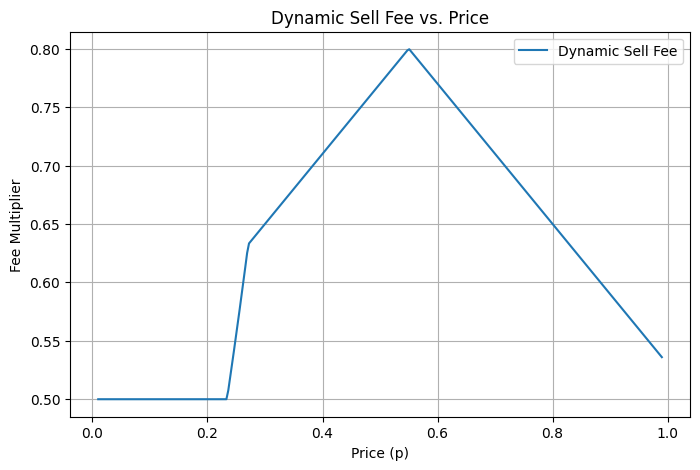

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the dynamic sell fee function:
reference_price = 0.55
base_fee = 0.8
slope = 0.6
min_fee = 0.50
max_edge_case_reward = 2

# Fix an amount and reserve for illustration:
amount = 15000
reserve = 30000

prices = np.linspace(0.01, 0.99, 300)  # price values between 0.2 and 0.8

# We'll compute the fee for each price using your dynamic_sell_fee.
fees = []
for p in prices:
    try:
        fee = dynamic_sell_fee(p, amount, reserve, reference_price, base_fee, slope, min_fee, max_edge_case_reward)
    except Exception as e:
        fee = np.nan
    fees.append(fee)

plt.figure(figsize=(8, 5))
plt.plot(prices, fees, label='Dynamic Sell Fee')
plt.xlabel('Price (p)')
plt.ylabel('Fee Multiplier')
plt.title('Dynamic Sell Fee vs. Price')
plt.legend()
plt.grid(True)
plt.show()


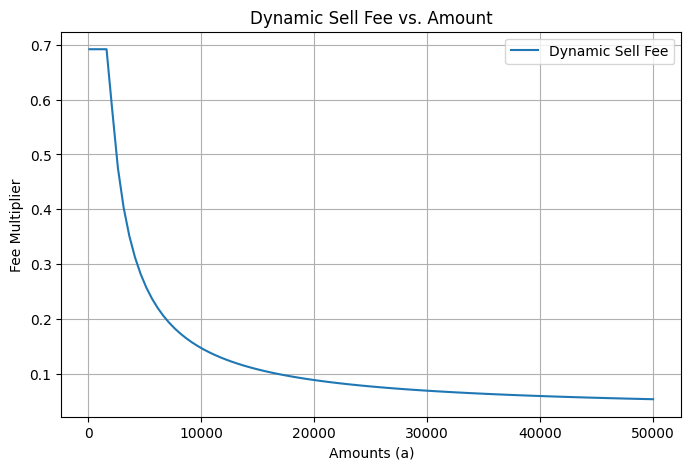

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the dynamic sell fee function:
reference_price = 0.55
base_fee = 0.8
slope = 0.2
min_fee = 0.010
max_edge_case_reward = 4
price = 0.01

reserve = 3_000_000

amounts = np.linspace(100, 50_000, 100)  # reserve values between 0.2 and 0.8

# We'll compute the fee for each price using your dynamic_sell_fee.
fees = []
for a in amounts:
    try:
        fee = dynamic_sell_fee(price, a, reserve, reference_price, base_fee, slope, min_fee, max_edge_case_reward)
    except Exception as e:
        fee = np.nan
    fees.append(fee)

plt.figure(figsize=(8, 5))
plt.plot(amounts, fees, label='Dynamic Sell Fee')
plt.xlabel('Amounts (a)')
plt.ylabel('Fee Multiplier')
plt.title('Dynamic Sell Fee vs. Amount')
plt.legend()
plt.grid(True)
plt.show()
